In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import pyodbc
import seaborn as sns
sns.set(style="ticks", palette="pastel")


In [2]:
def get_xcalar_connection(uid, psw, url, port):
    cstr = (
                "DRIVER=/Library/simba/spark/lib/libsparkodbc_sbu.dylib;" #{Simba Spark ODBC Driver 64-bit}
                "AuthMech=3;"
                "ThriftTransport=1;"
                "SparkServerType=3;"
                "LogLevel=6;"
                "SSL=0;"
                "UID=%s;"
                "PWD=%s;"
                "HOST=%s;"
                "PORT=%d;"
            ) % (uid, psw, url, port)

    conn = pyodbc.connect(cstr, autocommit=True)
    # ODBC default is UTF-16, python3 is UTF-8
    print(cstr)
    conn.setdecoding(pyodbc.SQL_CHAR, encoding='utf-8')
    conn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf-8')
    conn.setdecoding(pyodbc.SQL_WMETADATA, encoding='utf-8')
    conn.setencoding(encoding='utf-8')
    return conn

conn_qa = get_xcalar_connection('admin', 'admin', 'qa.xcalar.rocks', 10000)
# conn_qa = get_xcalar_connection('admin', 'admin', 'mingkevm2.int.xcalar.com', 10000)

DRIVER=/Library/simba/spark/lib/libsparkodbc_sbu.dylib;AuthMech=3;ThriftTransport=1;SparkServerType=3;LogLevel=6;SSL=0;UID=admin;PWD=admin;HOST=qa.xcalar.rocks;PORT=10000;


In [50]:
start_ts = '2020-07-11T10:55:12.000Z'
end_ts = '2021-07-15T22:22:44.973Z'

sql = """with cleanup as ( SELECT t.UNIVERSE, t.BATCH_ID, t.BATCH_UNIVERSE_ID, t.STAGE_DURATION_MIN, t.STAGE_END_TS, t.STAGE_START_TS, 
case when t.OBJECT_TYPE='analyzer' then 'IMD COMMIT' else t.CONTROLLER_STAGE end as CONTROLLER_STAGE
from CLR_STAGES T where 
t.batch_version=0 and 
t.CONTROLLER_STAGE in ('REFINER STARTING','IMD STARTING','BATCH START','SNAPSHOTTING','UNIVERSE LOAD STARTING','STARTING SNAPSHOT RECOVERY')),

stages as ( SELECT t.UNIVERSE, t.BATCH_ID, t.BATCH_UNIVERSE_ID, t.CONTROLLER_STAGE, t.STAGE_DURATION_MIN, 
MAX(t.STAGE_END_TS) as end_ts, MIN(t.STAGE_START_TS) as start_ts
from cleanup T 
--where t.UNIVERSE='REF' 
--where t.BATCH_ID >= 72
group by 1,2,3,4,5
--having MAX(t.STAGE_END_TS)>cast('{0}' as timestamp)
--and MIN(t.STAGE_START_TS)<cast('{1}' as timestamp)
), 
all as( SELECT t.UNIVERSE, t.BATCH_ID, t.BATCH_UNIVERSE_ID, MAX(t.end_ts) as end_ts, MIN(t.start_ts) as start_ts, sum(t.STAGE_DURATION_MIN) as full_batch_min 
from stages t group by 1,2,3 ) 

SELECT all.UNIVERSE, all.BATCH_ID, --all.start_ts, all.end_ts, 
cast(cast(all.start_ts as int)/60000 as int) as batch_start,
ROW_NUMBER() OVER(PARTITION by all.UNIVERSE ORDER BY all.start_ts ASC) AS batch_rn,
case when all.UNIVERSE = 'REF' then 'REF' when all.UNIVERSE like 'PC6%' or all.UNIVERSE like 'PC7%' then 'XXL' else 'SML' end as universe_type, 
(select coalesce(sum(az.row_count),0) from CLR_INCREMENTS az where all.BATCH_UNIVERSE_ID=az.BATCH_UNIVERSE_ID and az.TABLE_NAME='ValuedAsset') as refiner_counts, 
(select coalesce(sum(az.row_count),0) from CLR_INCREMENTS az where all.BATCH_UNIVERSE_ID=az.BATCH_UNIVERSE_ID and az.TABLE_NAME<>'ValuedAsset') as all_imd_counts, 
(select coalesce(sum(az.row_count),0) from CLR_APP_INPUTS az where all.BATCH_UNIVERSE_ID=az.BATCH_UNIVERSE_ID and az.SOURCE_DELTA_TABLE='PWM_Prices') as prices_input_rows, 
(select coalesce(sum(az.row_count),0) from CLR_APP_INPUTS az where all.BATCH_UNIVERSE_ID=az.BATCH_UNIVERSE_ID and az.SOURCE_UNIVERSE='REF') as ref_input_rows, 
(select coalesce(sum(az.row_count),0) from CLR_APP_INPUTS az where all.BATCH_UNIVERSE_ID=az.BATCH_UNIVERSE_ID and az.SOURCE_UNIVERSE=az.UNIVERSE) as self_input_rows, 
(select coalesce(sum(ao.row_count),0) from CLR_APP_INPUTS ao where all.BATCH_UNIVERSE_ID=ao.BATCH_UNIVERSE_ID) as all_input_rows, 

e1.STAGE_DURATION_MIN as refiner_mins, cast(cast(e1.start_ts as int)/60000 as int) as refiner_start, 
e2.STAGE_DURATION_MIN as imd_mins, cast(cast(e2.start_ts as int)/60000 as int) as imd_start,
e3.STAGE_DURATION_MIN as kafka_mins, cast(e3.start_ts as int)/60000 as kafka_start,
e4.STAGE_DURATION_MIN as snapshot_mins, cast(e4.start_ts as int)/60000 as snapshot_start,
e5.STAGE_DURATION_MIN as load_mins, cast(e5.start_ts as int)/60000 as load_start,
e6.STAGE_DURATION_MIN as recover_mins, cast(e6.start_ts as int)/60000 as recover_start
--,all.full_batch_min 
from all left join stages e1 on all.BATCH_UNIVERSE_ID=e1.BATCH_UNIVERSE_ID and e1.CONTROLLER_STAGE='REFINER STARTING' 
left join stages e2 on all.BATCH_UNIVERSE_ID=e2.BATCH_UNIVERSE_ID and e2.CONTROLLER_STAGE='IMD STARTING' 
left join stages e3 on all.BATCH_UNIVERSE_ID=e3.BATCH_UNIVERSE_ID and e3.CONTROLLER_STAGE='BATCH START' 
left join stages e4 on all.BATCH_UNIVERSE_ID=e4.BATCH_UNIVERSE_ID and e4.CONTROLLER_STAGE='SNAPSHOTTING' 
left join stages e5 on all.BATCH_UNIVERSE_ID=e5.BATCH_UNIVERSE_ID and e5.CONTROLLER_STAGE='UNIVERSE LOAD STARTING'
left join stages e6 on all.BATCH_UNIVERSE_ID=e6.BATCH_UNIVERSE_ID and e6.CONTROLLER_STAGE='STARTING SNAPSHOT RECOVERY' 
ORDER by batch_rn
""".format(start_ts, end_ts)
data = pd.read_sql_query(sql,conn_qa)
# data.columns = ["UNIVERSE","BATCH_ID","BATCH_START","BATCH_RN","UNIVERSE_TYPE","REFINER_COUNTS","ALL_IMD_COUNTS","ALL_INPUT_ROWS","REFINER_MINS","REFINER_START","IMD_MINS","IMD_START","KAFKA_MINS","KAFKA_START","SNAPSHOT_MINS","SNAPSHOT_START","LOAD_MINS","LOAD_START","RECOVER_MINS","RECOVER_START"]
data.columns = ["UNIVERSE","BATCH_ID","BATCH_START","BATCH_RN","UNIVERSE_TYPE",
                "REFINER_COUNTS","ALL_IMD_COUNTS","PRICES_INPUT_ROWS",
                "REF_INPUT_ROWS","SELF_INPUT_ROWS","ALL_INPUT_ROWS","REFINER_MINS",
                "REFINER_START","IMD_MINS","IMD_START","KAFKA_MINS","KAFKA_START",
                "SNAPSHOT_MINS","SNAPSHOT_START","LOAD_MINS","LOAD_START",
                "RECOVER_MINS","RECOVER_START"]
data["FULL_BATCH_MIN"] = data["REFINER_MINS"] + data["KAFKA_MINS"] + data["IMD_MINS"]
data.head()

,UNIVERSE,BATCH_ID,BATCH_START,BATCH_RN,UNIVERSE_TYPE,REFINER_COUNTS,ALL_IMD_COUNTS,PRICES_INPUT_ROWS,REF_INPUT_ROWS,SELF_INPUT_ROWS,...,IMD_START,KAFKA_MINS,KAFKA_START,SNAPSHOT_MINS,SNAPSHOT_START,LOAD_MINS,LOAD_START,RECOVER_MINS,RECOVER_START,FULL_BATCH_MIN
0,CS1R,1,26608896,1,SML,0,73250086,0,0,0,...,NaN,NaN,NaN,76.46,2.660891e+07,12.23,2.660890e+07,NaN,NaN,NaN
1,PC65R,1,26608949,1,XXL,0,1064033820,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.03,2.660896e+07,11.61,2.660895e+07,NaN
2,PC66R,1,26608955,1,XXL,0,1064033820,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.05,2.660897e+07,10.01,2.660896e+07,NaN
3,REF,1,26608932,1,REF,0,342842423,0,0,0,...,NaN,NaN,NaN,12.08,2.660897e+07,36.85,2.660893e+07,NaN,NaN,NaN
4,HK1R,1,26608902,1,SML,0,42974710,0,0,0,...,NaN,NaN,NaN,74.31,2.660891e+07,9.20,2.660890e+07,NaN,NaN,NaN


In [52]:
# tables = pd.read_sql_query("show tables",conn_qa)
# tables

In [48]:
def list_universes(data):
    udf = data[['UNIVERSE','UNIVERSE_TYPE']].drop_duplicates().sort_values('UNIVERSE_TYPE',ascending=False)
    udf['HEIGHT'] = np.where(udf['UNIVERSE_TYPE'] == 'SML', 0.3, 
                             np.where(udf['UNIVERSE_TYPE'] == 'REF', 0.6,
                                      np.where(udf['UNIVERSE'] == 'PC7R', 0.6, 0.95)))
    udf['key'] = udf['HEIGHT'].astype(str) + data['UNIVERSE']
    udf.sort_values('key',ascending=True, inplace=True)
    return udf

def filter_by_batch_id(data, start_batch, end_batch, universe, padding = 0):
    start_batch_ts = data[(data['UNIVERSE']==universe) & (data['BATCH_ID']>=start_batch)]['BATCH_START'].min() - padding
    end_batch_ts = data[(data['UNIVERSE']==universe) & (data['BATCH_ID']<=end_batch)]['BATCH_START'].max() + padding
    print(start_batch_ts, end_batch_ts)
#     print(data[(data['UNIVERSE']==universe) & (data['BATCH_ID']>=start_batch)]['BATCH_START'].min(), end_batch_ts)
    return data[(data['BATCH_START']>=start_batch_ts) & (data['BATCH_START']<=end_batch_ts)]

def filter_by_start_end(data, start_batch_ts, end_batch_ts):
    return data[(data['BATCH_START']>=start_batch_ts) & (data['BATCH_START']<=end_batch_ts)]

def normalize_times(data):
    df = data.copy()
    b0_min = df['BATCH_START'].min() - 0.01
    df['BATCH_START'] = (df['BATCH_START'] - b0_min)
    df['REFINER_START'] = (df['REFINER_START'] - b0_min)
    df['IMD_START'] = (df['IMD_START'] - b0_min)
    df['KAFKA_START'] = (df['KAFKA_START'] - b0_min)
    df['SNAPSHOT_START'] = (df['SNAPSHOT_START'] - b0_min)
    df['LOAD_START'] = (df['LOAD_START'] - b0_min)
    df['RECOVER_START'] = (df['RECOVER_START'] - b0_min)
    return df.merge(udf, on='UNIVERSE', how='inner')

def draw_timeline(udf, _data, wdth=18):
    heights=list(udf['HEIGHT'])
    r = range(len(heights))
    pallet = ['#f1eab3','#efbc4e','#9bbf80','#e4e1d3','#88befe','#acceee']
    fig, ax = plt.subplots(figsize=(wdth,len(heights) * 1))

    len_array = _data['BATCH_RN'].max() + 1
    for i in range(1,len_array):
        bdata = _data[_data['BATCH_RN']==i].sort_values('key',ascending=True)
        bdata = bdata.set_index("UNIVERSE").reindex(udf["UNIVERSE"])
        zz = zip(r, bdata['BATCH_START'], bdata['BATCH_ID'])
        for z in zz:
            if z[1] > 0:
                ax.text(z[1]+1,z[0],int(z[2]), ha='left', va='center',
                            color='#242123') 
        if bdata.size == 0: 
            print('quiting at',i)
        kbar = ax.barh(r, bdata['KAFKA_MINS'], left = bdata['BATCH_START'], color=pallet[0], edgecolor='white', height=heights)

        ibar = ax.barh(r, bdata['IMD_MINS'], left = bdata['IMD_START'], color=pallet[1], edgecolor='white', height=heights)
        rbar = ax.barh(r, bdata['REFINER_MINS'], left = bdata['REFINER_START'], color=pallet[2], edgecolor='white', height=heights)
        sbar = ax.barh(r, bdata['SNAPSHOT_MINS'], left = bdata['SNAPSHOT_START'], color=pallet[3], edgecolor='white', height=heights)

        lbar = ax.barh(r, bdata['LOAD_MINS'], left = bdata['LOAD_START'], color=pallet[4], edgecolor='white', height=heights)
        lsbar = ax.barh(r, bdata['RECOVER_MINS'], left = bdata['RECOVER_START'], color=pallet[5], edgecolor='white', height=heights)
        text_color = 'darkgrey'
            
    ax.set_yticks(r,minor=False )
    ax.set_yticklabels(list(udf['UNIVERSE']))
    ax.set_ylabel("premises", fontsize='small')
    ax.set_xlabel("minutes", fontsize='small')

    ax.legend([lbar, lsbar, kbar, ibar, rbar, sbar], ['Load','Recover','Kafka','IMD','Refiner', 'Snapshot'], bbox_to_anchor=(0, 1), ncol = 6,
              loc='lower left', fontsize='large')
    fig.savefig('/Users/nogievetsky/Downloads/temp.png', dpi=fig.dpi)
    plt.show()

def plot_sla(_data, dim, minrows, maxrows, measure='FULL_BATCH_MIN'):
    ss = _data[(data['UNIVERSE_TYPE'] == 'XXL') & (data[dim]>minrows) & (data[dim]<maxrows)]
    print('Numer of runs: ',len(ss))
    print('Refiner INPUT_ROWS between', minrows, 'and', maxrows)
    print('Avg refiner run: ',ss["REFINER_MINS"].mean())
    print('Avg full batch run: ',ss["FULL_BATCH_MIN"].mean())
    print('Max full batch run: ',ss["FULL_BATCH_MIN"].max())

    measures = ss[measure]
    l = list(measures.sort_values(ascending=True))
    pos95 = int(len(l)*0.95 - 0.5)
    if pos95 == 0:
        print('Not enough data')
        return
    sla95 = l[pos95]
    print('95 Percentile full batch run: ',sla95)

    sigma = measures.std()
    mu = measures.mean()
    plt.figure(figsize=(20,10))
    plt.plot([sla95,sla95],[0, .2], 'k-', lw=4, color='green')
    plt.hist(measures, 100, density=True, color='lightblue')
    plt.show()

26608890 26609132


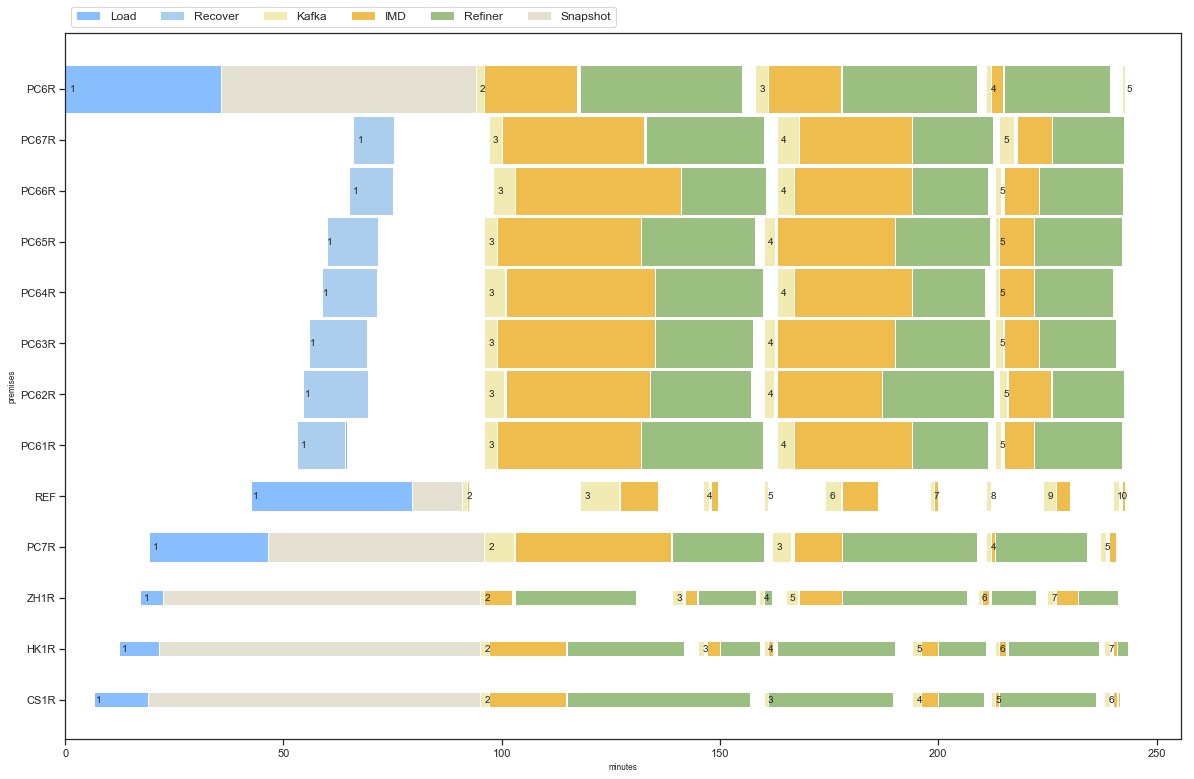

In [49]:
udf = list_universes(data)
dfd = filter_by_batch_id(data, 0, 1666, 'PC6R')
df = normalize_times(dfd)
draw_timeline(udf, df, 20)

Numer of runs:  28
Refiner INPUT_ROWS between 10 and 1000000000
Avg refiner run:  21.56
Avg full batch run:  45.26714285714286
Max full batch run:  64.03999999999999
95 Percentile full batch run:  63.76


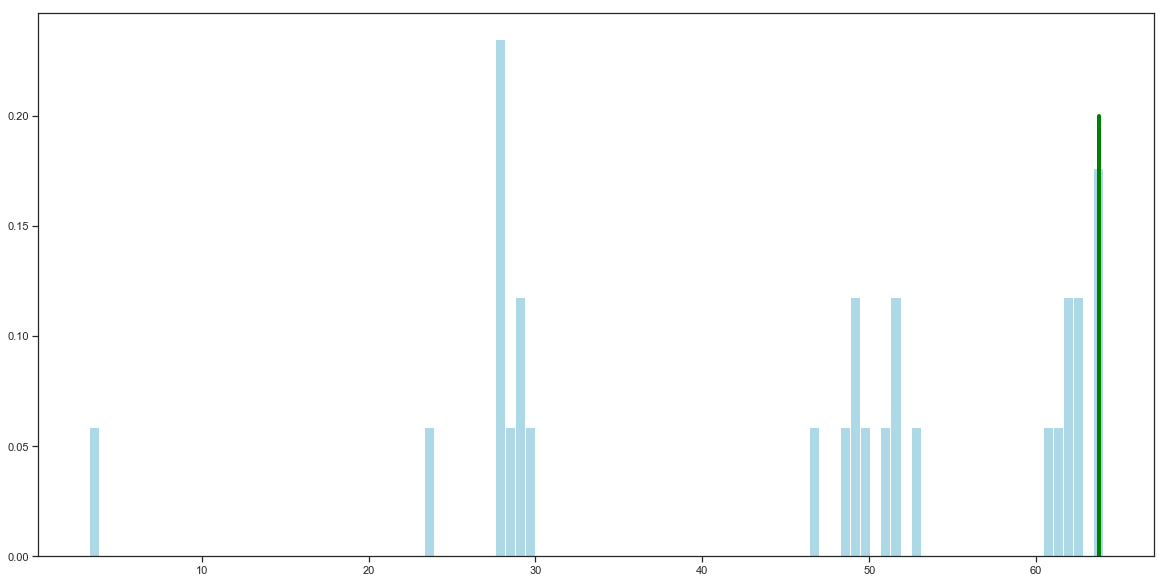

In [47]:
plot_sla(data, 'ALL_INPUT_ROWS', 10, 1000000000)

mean XXL(PC6x/7) refiner run 19.732105263157894
mean XXL(PC6x/7) full batch run 37.11


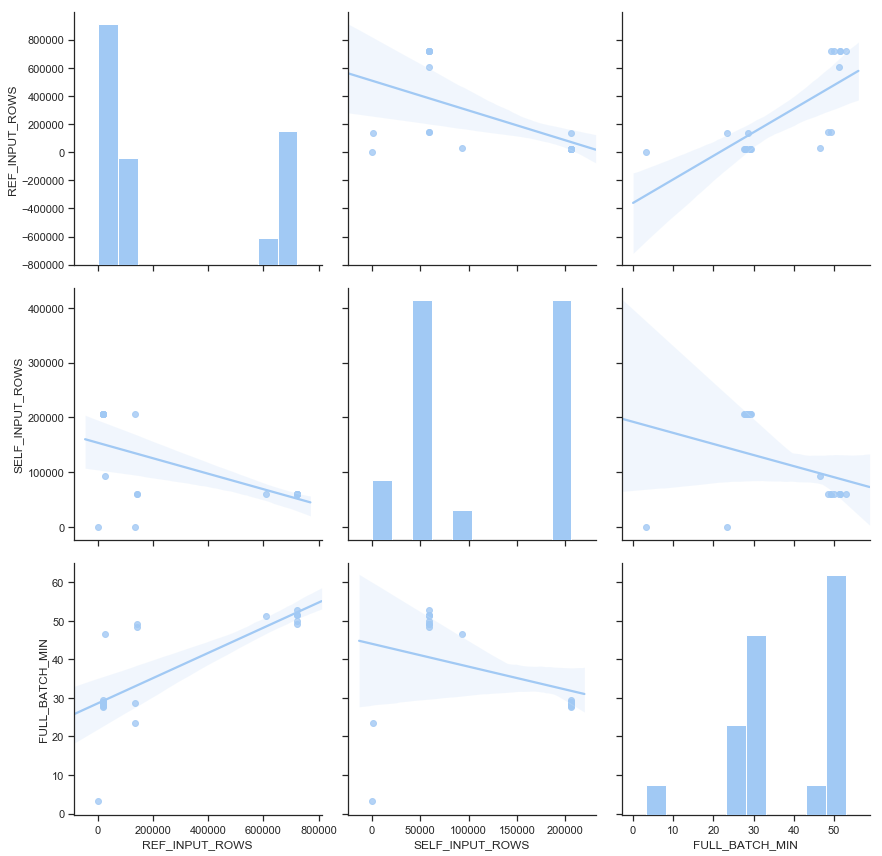

In [30]:

# ss = ctl[(ctl['UNIVERSE_TYPE'] == 'XXL') & (ctl['ALL_IMD_COUNTS']>8) & (ctl['BATCH_ID']>71)]
# ss = data[(data['UNIVERSE_TYPE'] == 'XXL') & (data['ALL_INPUT_ROWS']<10000000) & (data['ALL_INPUT_ROWS']>10) & (data['BATCH_START']>26620642+1300)]
ss = data[(data['UNIVERSE_TYPE'] == 'XXL') & (data['ALL_INPUT_ROWS']<1000000) & (data['ALL_INPUT_ROWS']>1)]
print('mean XXL(PC6x/7) refiner run',ss["REFINER_MINS"].mean())
print('mean XXL(PC6x/7) full batch run',ss["FULL_BATCH_MIN"].mean())

subset2 = ss[['REF_INPUT_ROWS', 'SELF_INPUT_ROWS',
              'FULL_BATCH_MIN',
              'UNIVERSE_TYPE']]
# ss.head()
sns_plot = sns.pairplot(subset2, height=4,  kind="reg")

# sns_plot = sns.pairplot(subset2, hue='UNIVERSE_TYPE', height=4 )
# sns_plot.savefig("/tmp/r_inputs_big_all_p0.png")

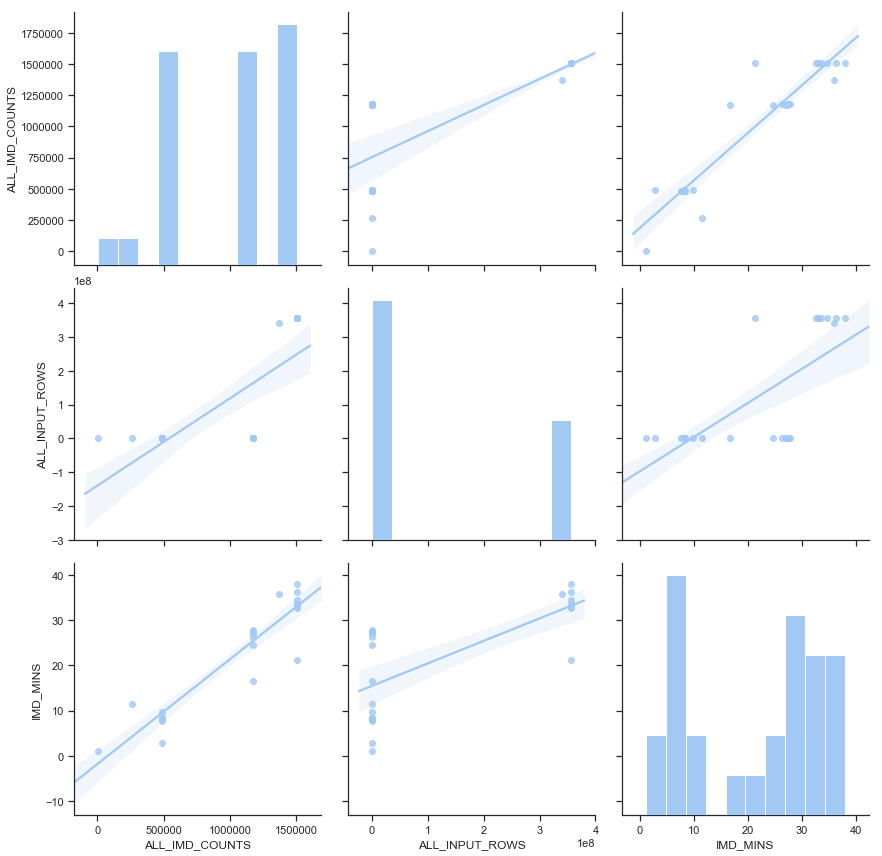

In [55]:
ss = data[(data['UNIVERSE_TYPE'] == 'XXL') & (data['ALL_IMD_COUNTS']>8)] #  & (data['BATCH_ID']>71)]
subset2 = ss[['ALL_IMD_COUNTS',
         'ALL_INPUT_ROWS', 'IMD_MINS','UNIVERSE_TYPE']].dropna()
sns_plot = sns.pairplot(subset2, height=4,  kind="reg")

All Premises


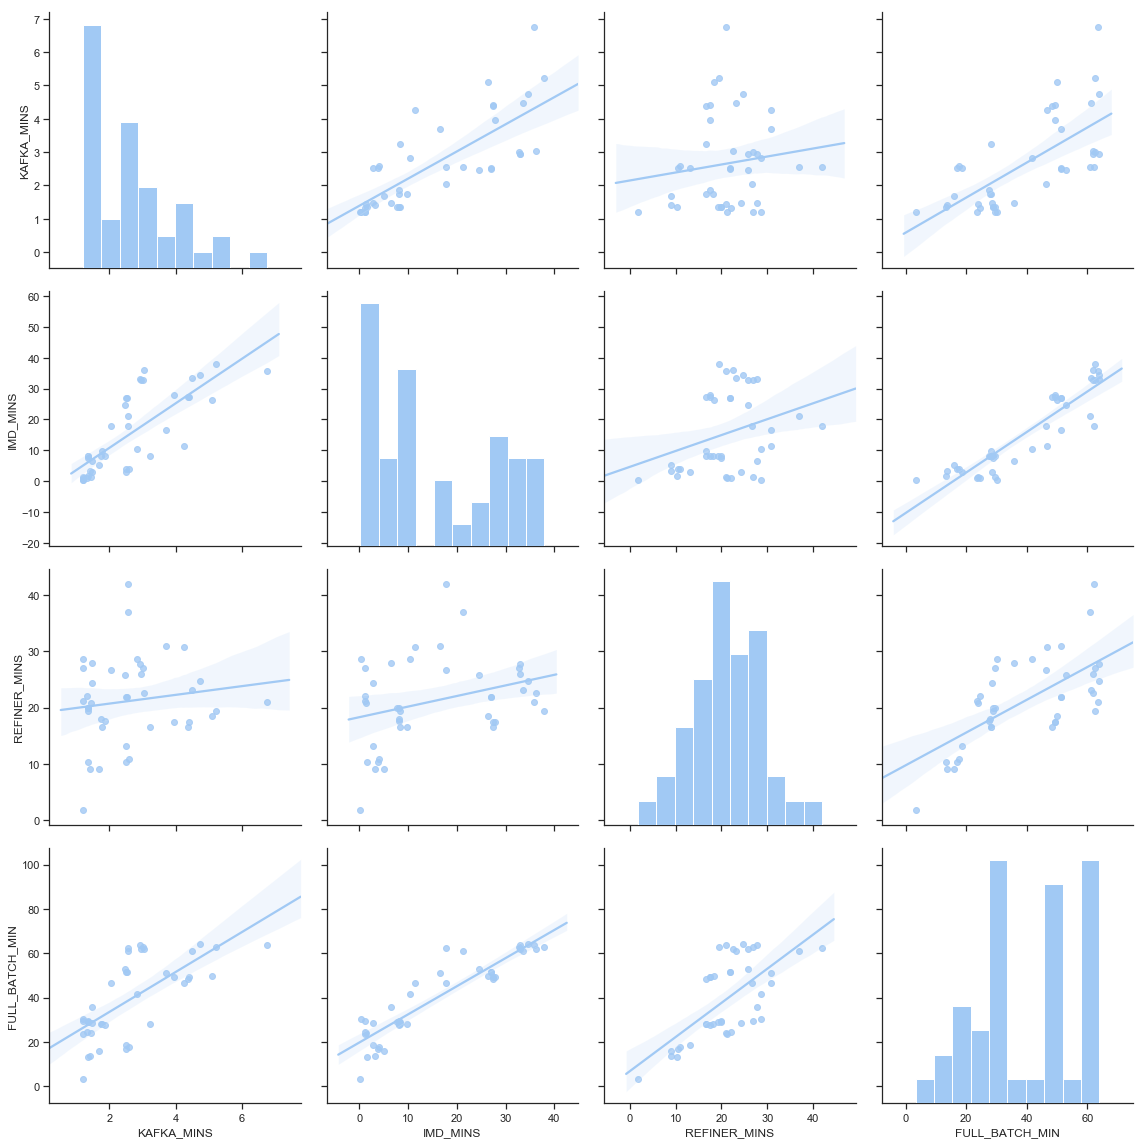

In [54]:
ss = data[(data['UNIVERSE_TYPE'] != 'REF') & (data['ALL_IMD_COUNTS']>8)]
subset_mins = ss[['KAFKA_MINS','IMD_MINS', 'REFINER_MINS', 'FULL_BATCH_MIN', 'UNIVERSE_TYPE']].dropna()

# sns_plot = sns.pairplot(subset_mins, hue='UNIVERSE_TYPE', height=4 )
sns_plot = sns.pairplot(subset_mins, height=4,  kind="reg")
print('All Premises')

In [59]:
sql = """with x as (SELECT OBJECT_TYPE,OPERATION_TYPE,
  t.UNIVERSE, t.BATCH_ID, --t.STAGE_DURATION_MIN, t.STAGE_START_TS, 
  case when t.OBJECT_TYPE='analyzer' then 'IMD COMMIT' else t.CONTROLLER_STAGE end as STAGE,
  UNIVERSE_TABLE_NAME,
  sxdf_cut(OBJECT_TYPE,2,UNIVERSE_TABLE_NAME) as verb,
  case when UNIVERSE = 'REF' then 'REF' when UNIVERSE like 'PC6%' or UNIVERSE like 'PC7%' then 'XXL' else 'SML' end as universe_size,
  sum(DELTA_ROW_COUNT) as DELTA_ROW_COUNT,
  sum(DURATION_SEC)as DURATION_SEC,
  --max(LOG_MSG) as sample_log_msg,
  count(*) as cnt
from CLR_STAGES T where t.batch_version=0 
and OBJECT_TYPE != 'uber'
and t.CONTROLLER_STAGE in ('REFINER STARTING','IMD STARTING')
--and t.CONTROLLER_STAGE in ('IMD STARTING')
--and t.CONTROLLER_STAGE in ('REFINER STARTING')
and DURATION_SEC > 0
group by 1,2,3,4,5,6,7,8
order by 10)
select * from x --where universe_size in ('XXL','SML')
"""
#--and CONTROLLER_STAGE != 'REFINER CYCLE FINISHED', ,'BATCH START'
# print(sql)

data = pd.read_sql_query(sql,conn)
data.columns = ['OBJECT_TYPE','OPERATION_TYPE','UNIVERSE', 'BATCH_ID', 'STAGE', 
                'TABLE_NAME', 'VERB', 'SIZE', 'DELTA_ROW_COUNT', 'DURATION_SEC', 'cnt']
print(data.size)
data.head()

38093


,OBJECT_TYPE,OPERATION_TYPE,UNIVERSE,BATCH_ID,STAGE,TABLE_NAME,VERB,SIZE,DELTA_ROW_COUNT,DURATION_SEC,cnt
0,offsets_commit,MERGE_OTHER,PC6R,15,REFINER STARTING,offsets_commit,,XXL,NaN,0.006,1
1,offsets_commit,MERGE_OTHER,PC6R,89,REFINER STARTING,offsets_commit,,XXL,NaN,0.006,1
2,offsets_commit,MERGE_OTHER,PC6R,12,REFINER STARTING,offsets_commit,,XXL,NaN,0.006,1
3,offsets_commit,MERGE_OTHER,PC6R,55,REFINER STARTING,offsets_commit,,XXL,NaN,0.006,1
4,offsets_commit,MERGE_OTHER,PC6R,75,IMD STARTING,offsets_commit,,XXL,NaN,0.006,1


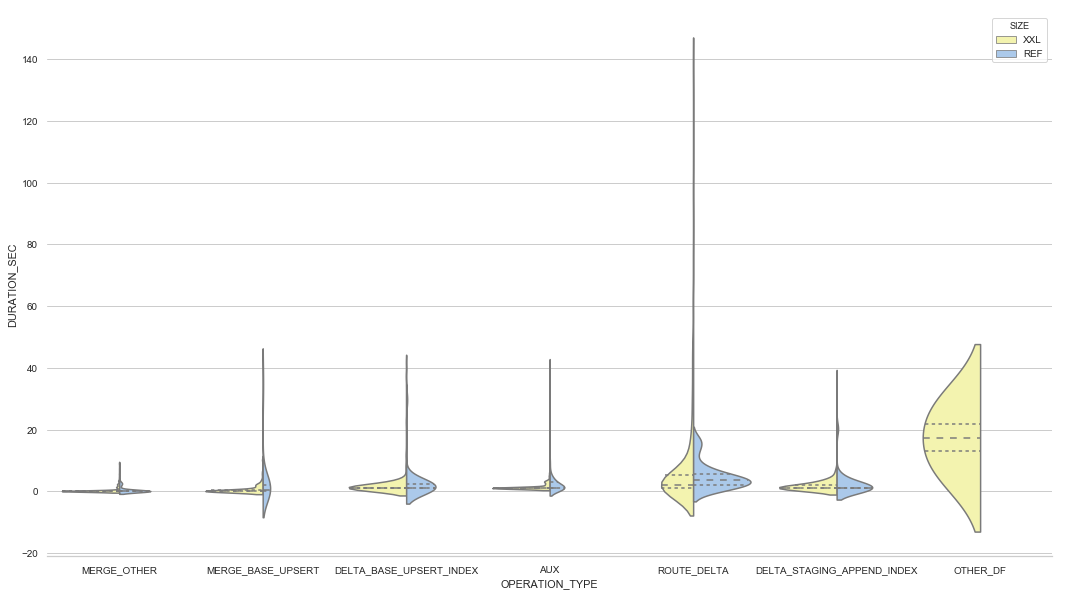

In [60]:
# sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=.5, rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=.9, rc={'figure.figsize':(18,10)})
sns.violinplot(x="OPERATION_TYPE", y="DURATION_SEC", hue='SIZE', inner="quart",split=True,
            palette={"XXL": "y", "REF": "b"},
            data=data[data['STAGE'] == 'IMD STARTING'])

sns.despine(left=True)

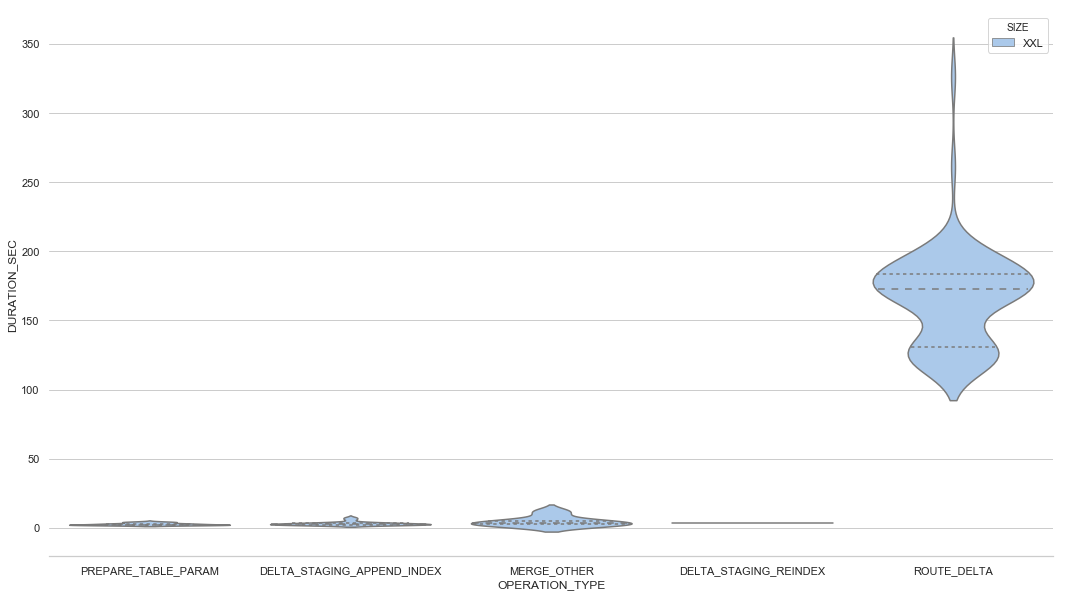

In [51]:
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1, rc={'figure.figsize':(18,10)})
# sns.set(style="whitegrid", font_scale=.6)
sns.violinplot(x="OPERATION_TYPE", y="DURATION_SEC", hue='SIZE', inner="quart",#split=True,
            #palette={"XXL": "y", "REF": "b"},
            data=data
#                [((data['STAGE'] == 'REFINER STARTING') | (data['STAGE'] == 'IMD STARTING')) & (data['SIZE'] == 'XXL')]
               [((data['STAGE'] == 'REFINER STARTING') ) & (data['SIZE'] == 'XXL')]
              )

sns.despine(left=True)

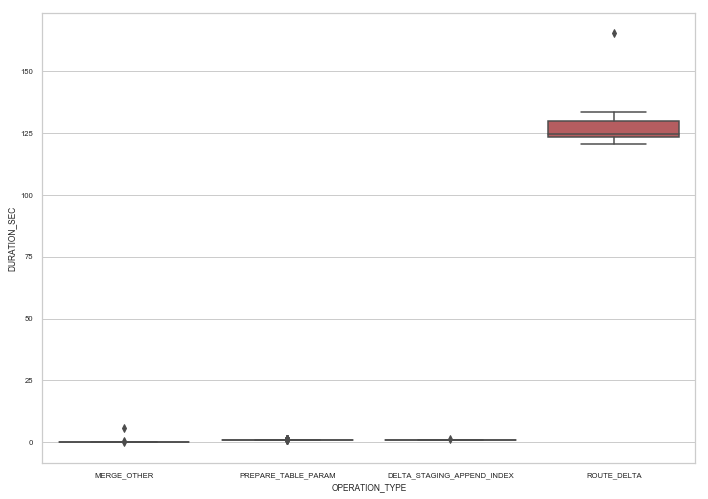

In [61]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid", font_scale=.7)
sns.boxplot(x="OPERATION_TYPE", y="DURATION_SEC",
            data=data[((data['STAGE'] == 'REFINER STARTING') ) & (data['SIZE'] == 'XXL') & (data['BATCH_ID'] >= 72)])
# sns.despine(offset=10, trim=True)

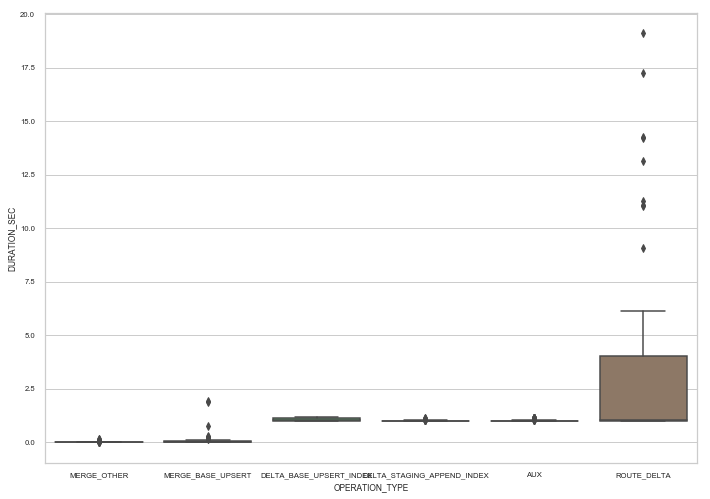

In [62]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid", font_scale=.7)
sns.boxplot(x="OPERATION_TYPE", y="DURATION_SEC",
            data=data[((data['STAGE'] == 'IMD STARTING') ) & (data['SIZE'] == 'XXL') & (data['BATCH_ID'] >= 72)])
# sns.despine(offset=10, trim=True)